# The Goal
- Retrain all best-performing model architectures / hyperparameters on normalized data

# Step 1: Loading datasets and best-performing models

In [15]:
import tensorflow as tf
import sklearn
import numpy as np
from numpy import where
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import TensorBoard
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split, PredefinedSplit, cross_val_predict, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, f1_score, auc, roc_curve, precision_recall_curve, average_precision_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import collections
from collections import Counter
import logging
import os
import sys
import xgboost as xgb
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler


In [3]:
# preparing datasets
df = pd.read_csv('./creditcard.csv')
X = df.drop('Class', axis=1).values
Y = df.Class.values

seed = 1234
tf.random.set_seed(seed)
np.random.seed(seed)

x, x_test, y, y_test = train_test_split(X, Y, test_size=0.15, shuffle=True, random_state=seed)
x_train, x_cv, y_train, y_cv = train_test_split(x, y, test_size=0.15, shuffle=True, random_state=seed)

# applying SMOTE
smote = SMOTE()
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

# applying stratified random sample
x, x_test_strat, y, y_test_strat = train_test_split(X, Y, test_size=0.15, shuffle=True, random_state=seed, stratify=Y)
x_train_strat, x_cv_strat, y_train_strat, y_cv_strat = train_test_split(x, y, test_size=0.15, shuffle=True, random_state=seed, stratify=y)


In [93]:
# loading best performing models
lgmodel_best = tf.keras.models.load_model('./models/lgmodel_v6')
nnmodel_best = tf.keras.models.load_model('./models/nnmodel_v6')
xgbmodel_best = XGBClassifier()
xgbmodel_best.load_model('./models/xgbmodel_v4.json')

## Step 2: Generate Normalized Data
Using minmax scaler

In [58]:
scaler=MinMaxScaler()
datasets = [x_cv, x_test, x_train_smote,x_train_strat]
norm_datasets = []
for set in datasets:
    normalized = scaler.fit_transform(set)
    norm_datasets.append(normalized)


## Step 3: Train models on normalized data
### logistic regression model

In [59]:
## logistic regression

def create_lg_model(lglambda=0, threshold=0.5, auc_curve="ROC", input_shape=0):
    seed=1234
    tf.random.set_seed(seed)
    np.random.seed(seed)

    model = tf.keras.Sequential()

    if input_shape != 0:
        model.add(tf.keras.Input(input_shape, ))

    model.add(tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(l=lglambda)))

    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        metrics=[tf.keras.metrics.AUC(curve=auc_curve), tf.keras.metrics.Precision(thresholds=threshold), tf.keras.metrics.Recall(thresholds=threshold)]
    )

    return model

In [60]:
index = datasets.index(x_train_smote)

m = create_lg_model(lglambda=0.01, input_shape=(norm_datasets[index].shape[1]))
m.fit(norm_datasets[index], y_train_smote, epochs=25, validation_data = (norm_datasets[0], y_cv))


/Users/solinakim/opt/anaconda3/envs/mypython3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


Train on 410818 samples, validate on 36313 samples
Epoch 1/25
410818/410818 [==============================] - 23s 57us/sample - loss: 0.4922 - auc_1: 0.9781 - precision_1: 0.9976 - recall_1: 0.8092 - val_loss: 0.3318 - val_auc_1: 0.9744 - val_precision_1: 0.8750 - val_recall_1: 0.7292
Epoch 2/25
410818/410818 [==============================] - 21s 52us/sample - loss: 0.4898 - auc_1: 0.9790 - precision_1: 0.9994 - recall_1: 0.8132 - val_loss: 0.3647 - val_auc_1: 0.9722 - val_precision_1: 0.8605 - val_recall_1: 0.7708
Epoch 3/25
410818/410818 [==============================] - 23s 55us/sample - loss: 0.4896 - auc_1: 0.9786 - precision_1: 0.9995 - recall_1: 0.8131 - val_loss: 0.3422 - val_auc_1: 0.9705 - val_precision_1: 0.8780 - val_recall_1: 0.7500
Epoch 4/25
410818/410818 [==============================] - 22s 53us/sample - loss: 0.4896 - auc_1: 0.9791 - precision_1: 0.9995 - recall_1: 0.8131 - val_loss: 0.3389 - val_auc_1: 0.9783 - val_precision_1: 0.8780 - val_recall_1: 0.7500
Epoch

INFO:tensorflow:Assets written to: ./models/lgmodel_v7/assets
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     36265
           1       0.84      0.79      0.82        48

    accuracy                           1.00     36313
   macro avg       0.92      0.90      0.91     36313
weighted avg       1.00      1.00      1.00     36313



'roc auc score: 0.8957368215451077'

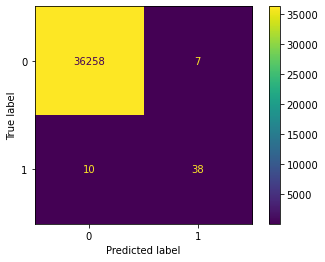

In [68]:
m.save('./models/lgmodel_v7')
preds = m.predict_proba(norm_datasets[0])
pred_class = list((preds >= 0.5).astype(int))
pred_class = list(map(lambda x: x[0], pred_class))

cm = confusion_matrix(y_cv, pred_class)
dp1 = ConfusionMatrixDisplay(confusion_matrix=cm)
dp1.plot()
print(classification_report(y_cv, pred_class))
display(f'roc auc score: {roc_auc_score(y_cv, pred_class)}')


Comparing performance to original best performing lgmodel

'optimal threshold: 1.0'

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     36265
           1       0.61      0.77      0.68        48

    accuracy                           1.00     36313
   macro avg       0.80      0.89      0.84     36313
weighted avg       1.00      1.00      1.00     36313



'roc auc score: 0.8850857691070363'

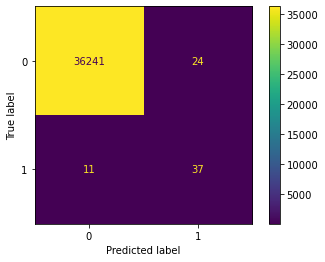

In [62]:
preds = lgmodel_best.predict_proba(x_cv)
fpr, tpr, thresholds = roc_curve(y_cv, preds)
opt_index = np.argmax(tpr-fpr)
opt_threshold = thresholds[opt_index]
display(f'optimal threshold: {opt_threshold}')

pred_class = list((preds >= opt_threshold).astype(int))
pred_class = list(map(lambda x: x[0], pred_class))

cm = confusion_matrix(y_cv, pred_class)
dp1 = ConfusionMatrixDisplay(confusion_matrix=cm)
dp1.plot()
print(classification_report(y_cv, pred_class))
display(f'roc auc score: {roc_auc_score(y_cv, pred_class)}')


- before normalization: macro avg f1 0.84
- after normalization: macro avg f1 0.91

### training neural network

In [69]:
m = Sequential() 
m.add(Dense(128, activation='relu', input_dim=30))
m.add(Dense(1, activation='sigmoid')) 
m.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
index = datasets.index(x_train_strat)
hist = m.fit(norm_datasets[index], y_train_strat, validation_data=(norm_datasets[0], y_cv), epochs=10, batch_size=100)
m.save('./models/nnmodel_v7')

/Users/solinakim/opt/anaconda3/envs/mypython3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """


Train on 205772 samples, validate on 36313 samples
Epoch 1/10
205772/205772 [==============================] - 7s 32us/sample - loss: 0.0127 - accuracy: 0.9973 - val_loss: 0.0044 - val_accuracy: 0.9990
Epoch 2/10
205772/205772 [==============================] - 5s 26us/sample - loss: 0.0052 - accuracy: 0.9989 - val_loss: 0.0033 - val_accuracy: 0.9994
Epoch 3/10
205772/205772 [==============================] - 5s 26us/sample - loss: 0.0048 - accuracy: 0.9991 - val_loss: 0.0031 - val_accuracy: 0.9994
Epoch 4/10
205772/205772 [==============================] - 5s 25us/sample - loss: 0.0046 - accuracy: 0.9991 - val_loss: 0.0034 - val_accuracy: 0.9996
Epoch 5/10
205772/205772 [==============================] - 5s 24us/sample - loss: 0.0045 - accuracy: 0.9992 - val_loss: 0.0030 - val_accuracy: 0.9995
Epoch 6/10
205772/205772 [==============================] - 7s 36us/sample - loss: 0.0044 - accuracy: 0.9992 - val_loss: 0.0028 - val_accuracy: 0.9993
Epoch 7/10
205772/205772 [=================

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     36265
           1       0.78      0.83      0.81        48

    accuracy                           1.00     36313
   macro avg       0.89      0.92      0.90     36313
weighted avg       1.00      1.00      1.00     36313



'roc auc score: 0.9165150052851695'

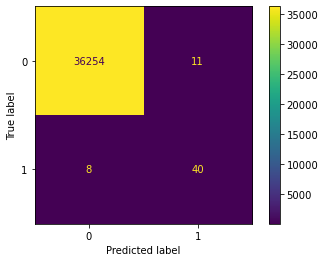

In [70]:
y_predicted = m.predict(norm_datasets[0]) > 0.5 # testing on original cv set for valid comparison to previous models
cm = confusion_matrix(y_cv, y_predicted)
dp1 = ConfusionMatrixDisplay(confusion_matrix=cm)
dp1.plot()
print(classification_report(y_cv, y_predicted))
display(f'roc auc score: {roc_auc_score(y_cv, y_predicted)}')


Comparing to original best nn model

'optimal threshold: 1.0'

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     36265
           1       0.73      0.77      0.75        48

    accuracy                           1.00     36313
   macro avg       0.86      0.89      0.87     36313
weighted avg       1.00      1.00      1.00     36313



'roc auc score: 0.8852236430902156'

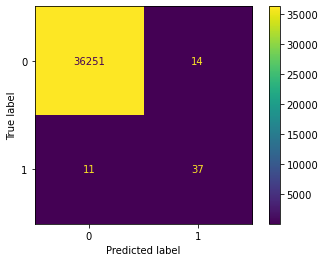

In [74]:
preds = nnmodel_best.predict_proba(x_cv)
fpr, tpr, thresholds = roc_curve(y_cv, preds)
opt_index = np.argmax(tpr-fpr)
opt_threshold = thresholds[opt_index]
display(f'optimal threshold: {opt_threshold}')

pred_class = list((preds >= opt_threshold).astype(int))
pred_class = list(map(lambda x: x[0], pred_class))

cm = confusion_matrix(y_cv, pred_class)
dp1 = ConfusionMatrixDisplay(confusion_matrix=cm)
dp1.plot()
print(classification_report(y_cv, pred_class))
display(f'roc auc score: {roc_auc_score(y_cv, pred_class)}')


- original best nn model before threshold tuning: macro avg f1 0.79
- original best nn model after threshold tuning: macro avg f1 0.87
- new best nn model after normalization & threshold tuning: macro avg f1 0.90

### Training xgboost model

In [77]:
m = XGBClassifier(n_estimators=100)
index = datasets.index(x_train_smote)
m.fit(norm_datasets[index], y_train_smote)


/Users/solinakim/opt/anaconda3/envs/mypython3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  
/Users/solinakim/opt/anaconda3/envs/mypython3.6/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:37:14] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     36265
           1       0.78      0.38      0.51        48

    accuracy                           1.00     36313
   macro avg       0.89      0.69      0.75     36313
weighted avg       1.00      1.00      1.00     36313



'roc auc score: 0.6874310630084104'

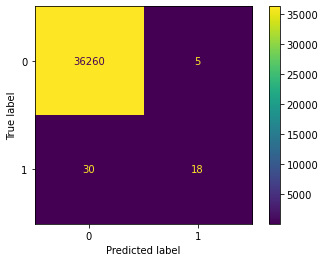

In [96]:
m.save_model('./models/xgbmodel_v7_1')
pred_class = m.predict(norm_datasets[0])
cm = confusion_matrix(y_cv, pred_class)
dp1 = ConfusionMatrixDisplay(confusion_matrix=cm)
dp1.plot()
print(classification_report(y_cv, pred_class))
display(f'roc auc score: {roc_auc_score(y_cv, pred_class)}')


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     36265
           1       0.86      0.90      0.88        48

    accuracy                           1.00     36313
   macro avg       0.93      0.95      0.94     36313
weighted avg       1.00      1.00      1.00     36313



'roc auc score: 0.9478201548784412'

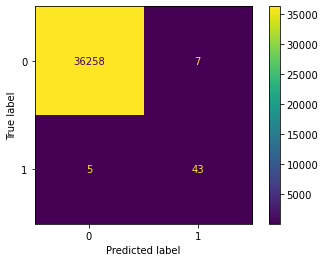

In [94]:
pred_class = xgbmodel_best.predict(x_cv)
cm = confusion_matrix(y_cv, pred_class)
dp1 = ConfusionMatrixDisplay(confusion_matrix=cm)
dp1.plot()
print(classification_report(y_cv, pred_class))
display(f'roc auc score: {roc_auc_score(y_cv, pred_class)}')


Original xgboost model performs better. Experimenting xgboost model on stratified, normalized training set.

/Users/solinakim/opt/anaconda3/envs/mypython3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  
/Users/solinakim/opt/anaconda3/envs/mypython3.6/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:48:29] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     36265
           1       0.86      0.79      0.83        48

    accuracy                           1.00     36313
   macro avg       0.93      0.90      0.91     36313
weighted avg       1.00      1.00      1.00     36313



'roc auc score: 0.8957506089434256'

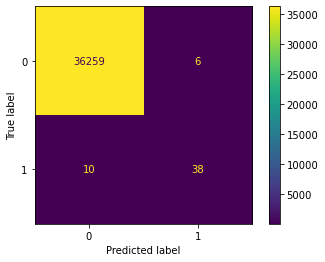

In [97]:
m = XGBClassifier(n_estimators=100)
index = datasets.index(x_train_strat)
m.fit(norm_datasets[index], y_train_strat)

m.save_model('./models/xgbmodel_v7_2')
pred_class = m.predict(norm_datasets[0])
cm = confusion_matrix(y_cv, pred_class)
dp1 = ConfusionMatrixDisplay(confusion_matrix=cm)
dp1.plot()
print(classification_report(y_cv, pred_class))
display(f'roc auc score: {roc_auc_score(y_cv, pred_class)}')


In [98]:
m.save_model('./models/xgbmodel_v7')


Highest f1 score is still with not normalized, SMOTE dataset